In [2]:
cd ..

/Users/julieneg/Documents/GitHub/Pyleoclim_util


In [18]:
import pyleoclim as pyleo
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from sklearn import metrics
pyleo.set_style('journal')

# load the data
data = sio.loadmat('./example_data/wtc_test_data_nino.mat')
nino = data['nino'][:, 0]
t = data['datayear'][:, 0]

In [32]:
y = nino
g =  0.7
ar = np.r_[1, -g]  # AR model parameter
ma = np.r_[1, 0.0]  # MA model parameters
sig = np.std(y)
sig_n = sig*np.sqrt(1-g**2) 

print(sig_n)

0.5868006326366701


In [25]:
def ar1_fit_evenly(y, t):
#  def ar1_fit_evenly(y, t, detrend=False, params=["default", 4, 0, 1], gaussianize=False):
    ''' Returns the lag-1 autocorrelation from AR(1) fit.

    Parameters
    ----------
    y : array
        vector of (float) numbers as a time series
    t : array
        The time axis for the timeseries.

    Returns
    -------
    g : float
        lag-1 autocorrelation coefficient

    '''
    #  pd_y = preprocess(y, t, detrend=detrend, params=params, gaussianize=gaussianize)
    #  ar1_mod = sm.tsa.AR(pd_y, missing='drop').fit(maxlag=1)
    #ar1_mod = sm.tsa.AR(y, missing='drop').fit(maxlag=1)
    #g = ar1_mod.params[1]

    # syntax compatible with statsmodels v0.11.1
    #ar1_mod = sm.tsa.ARMA(y, (1, 0), missing='drop').fit(trend='nc', disp=0)
    # syntax compatible with statsmodels v0.12
    ar1_mod = ARIMA(y, order = (1, 0, 0), missing='drop',trend='ct').fit()
    g = ar1_mod.params[0]

    if g > 1:
        print('Warning: AR(1) fitted autocorrelation greater than 1; setting to 1-eps^{1/4}')
        eps = np.spacing(1.0)
        g = 1.0 - eps**(1/4)

    return g


In [28]:
g = ar1_fit_evenly(y,t)
print(g)

-0.02286266116202256


In [36]:
from statsmodels.tsa.arima_process import arma_generate_sample

p = 10
n = np.size(y)
Yr = np.empty(shape=(n, p))  # declare array

# specify model parameters (statmodel want lag0 coefficent as unity)
ar = np.r_[1, -g]  # AR model parameter
ma = np.r_[1, 0.0]  # MA model parameters
sig_n = sig*np.sqrt(1-g**2)  # theoretical noise variance for the process to achieve the same variance as y

# simulate AR(1) model for each column
for i in np.arange(p):
    Yr[:, i] = arma_generate_sample(ar, ma, nsample=n, scale=sig_n, burnin=50) # statsmodels v0.12+

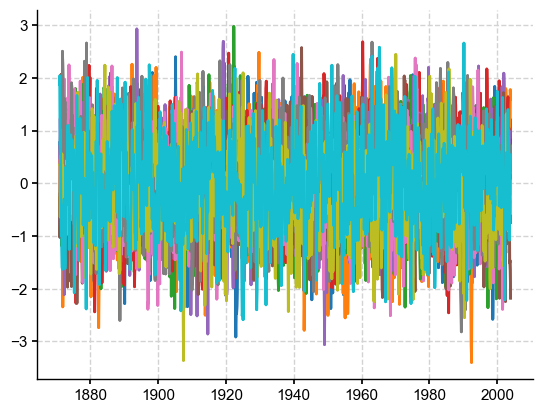

In [38]:
plt.plot(t,Yr)
plt.show()

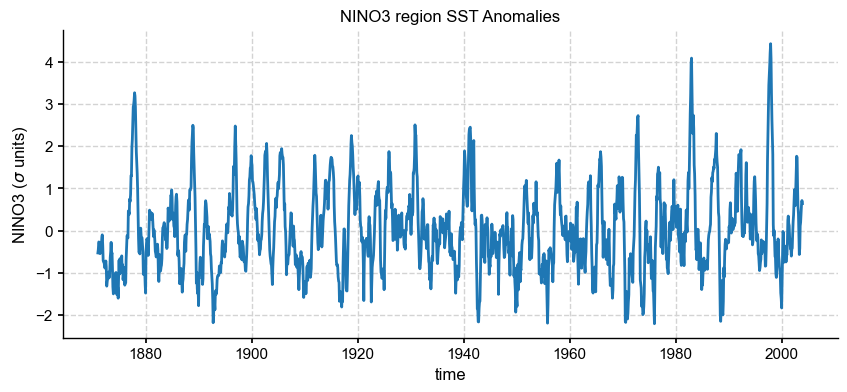

In [7]:
ts_nino = pyleo.Series(time=t, value=nino)
ts_n    = ts_nino.standardize()
fig, ax = ts_n.plot(title='NINO3 region SST Anomalies',mute=True)
ax.set_ylabel(r'NINO3 ($\sigma$ units)')
pyleo.showfig(fig)

In [8]:
nino_ssa = ts_n.ssa(M = 60)

In [9]:
d  = nino_ssa['eig_val'] # extract eigenvalue vector
M  = len(d)  # infer window size
de = d*np.sqrt(2/(M-1))
var_pct = d**2/np.sum(d**2)*100  # extract the fraction of variance attributable to each mode
r = 20
rk = np.arange(0,r)+1

assert np.abs(var_pct[15:].sum()*100-4.825612144779388) < 1e-6

/Users/julieneg/opt/miniconda3/envs/pyleo/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


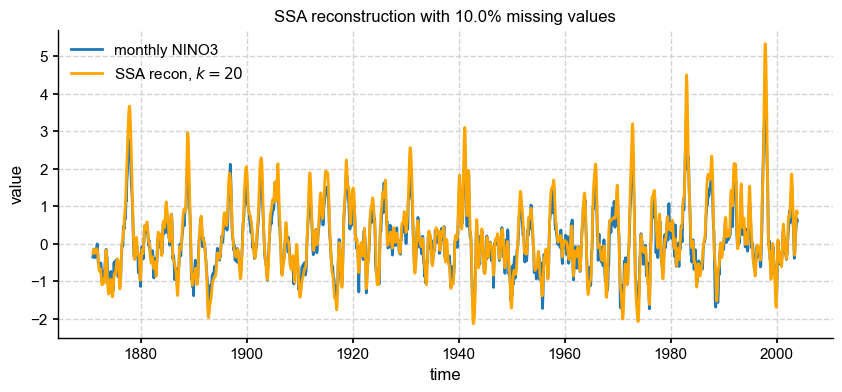

In [19]:
nino_mcssa = ts_n.ssa(M = 60, nMC=1000)
#assert what?

# SSA with missing values
n = len(nino)
fm = 0.1  #fraction of missing values
missing = np.random.choice(n,np.floor(fm*n).astype('int'),replace=False)
nino_miss = np.copy(ts_n.value)
nino_miss[missing] = np.nan  # put NaNs at the randomly chosen locations
ts_miss = pyleo.Series(time=t,value=nino_miss,clean_ts=False)
miss_ssa = ts_miss.ssa(M = 60)
RCmiss = miss_ssa['RC'][:,:19].sum(axis=1)

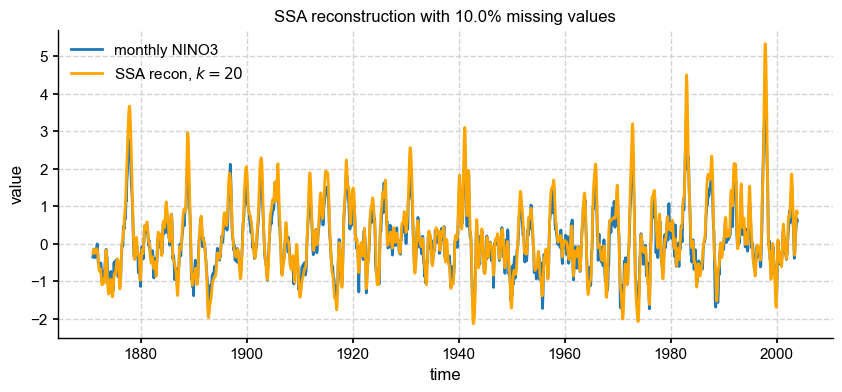

In [20]:
fig, ax = ts_nino.plot(title=r'SSA reconstruction with '+ str(fm*100) +'% missing values',mute=True,label='monthly NINO3')
ax.plot(t,RCmiss,label='SSA recon, $k=20$',color='orange')
ax.legend()
pyleo.showfig(fig)

In [25]:
MSE = metrics.mean_squared_error(nino, RCmiss)
assert MSE < 0.1

In [26]:
ssa?

Object `ssa` not found.


In [27]:
ts_n.ssa?